In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device # 这里是设置跑程序采用CPU还是GPU

device(type='cuda')

In [3]:
# 首先，装在CIFAR10数据集

In [4]:
train_data = torchvision.datasets.CIFAR10('data',train=True,transform=torchvision.transforms.ToTensor(),download=False)
test_data = torchvision.datasets.CIFAR10('data',train=False,transform=torchvision.transforms.ToTensor(),download=False)

In [5]:
batch_size = 32

In [6]:
train_data = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=True)
test_data = torch.utils.data.DataLoader(test_data,batch_size=32)

In [7]:
imgs, labels = next(iter(train_data))

In [8]:
imgs.shape,labels

(torch.Size([32, 3, 32, 32]),
 tensor([5, 6, 3, 0, 6, 2, 0, 8, 3, 1, 5, 7, 4, 3, 2, 9, 2, 9, 3, 8, 2, 9, 7, 2,
         2, 6, 8, 1, 2, 1, 0, 4]))

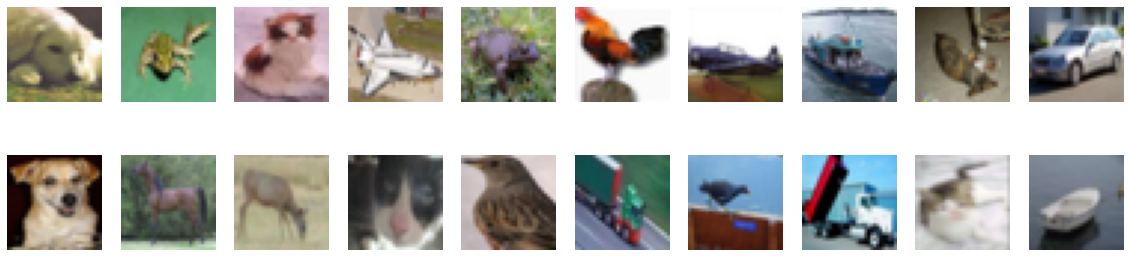

In [9]:
# 指定图片大小，图像大小为20宽、5高的绘图(单位为英寸inch)
plt.figure(figsize=(20, 5)) 
for i, imgs in enumerate(imgs[:20]):
    # 维度缩减
    npimg = imgs.numpy().transpose((1, 2, 0))
    # 将整个figure分成2行10列，绘制第i+1个子图。
    plt.subplot(2, 10, i+1)
    plt.imshow(npimg, cmap=plt.cm.binary)
    plt.axis('off')

In [10]:
num_classes = 10

In [11]:
# 这里需要注意网络数据shape的方法，需要判断输出数据的shape

In [12]:
class Model(nn.Module):
     def __init__(self):
        super().__init__()
         # 特征提取网络
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)   # 第一层卷积,卷积核大小为3*3
        self.pool1 = nn.MaxPool2d(kernel_size=2)       # 设置池化层，池化核大小为2*2
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)  # 第二层卷积,卷积核大小为3*3   
        self.pool2 = nn.MaxPool2d(kernel_size=2) 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3) # 第二层卷积,卷积核大小为3*3   
        self.pool3 = nn.MaxPool2d(kernel_size=2) 
                                      
        # 分类网络
        self.fc1 = nn.Linear(512, 256)          
        self.fc2 = nn.Linear(256, num_classes)
     # 前向传播
     def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))     
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        
        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
       
        return x

In [13]:
from torchinfo import summary
# 将模型转移到GPU中（我们模型运行均在GPU中进行）
model = Model().to(device)

summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Conv2d: 1-1                            1,792
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            36,928
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            73,856
├─MaxPool2d: 1-6                         --
├─Linear: 1-7                            131,328
├─Linear: 1-8                            2,570
Total params: 246,474
Trainable params: 246,474
Non-trainable params: 0

In [14]:
loss_fn = nn.CrossEntropyLoss()
lr = 0.01
opt = torch.optim.SGD(model.parameters(),lr=lr)

In [24]:
def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    train_acc,train_loss = 0,0
    for X,y in dataloader:
        X,y = X.to(device),y.to(device)
        pred = model(X)
        loss = loss_fn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
    train_acc  /= size
    train_loss /= num_batches
    return train_acc,train_loss

In [16]:
def test (dataloader, model, loss_fn):
    size        = len(dataloader.dataset)  # 测试集的大小，一共10000张图片
    num_batches = len(dataloader)          # 批次数目，313（10000/32=312.5，向上取整）
    test_loss, test_acc = 0, 0
    
    # 当不进行训练时，停止梯度更新，节省计算内存消耗
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            # 计算loss
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss

In [25]:
epochs     = 10
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []
for epoch in range(epochs):
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_data, model, loss_fn, opt)
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_data, model, loss_fn)
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, epoch_test_acc*100, epoch_test_loss))
print('Done')

Epoch: 1, Train_acc:24.8%, Train_loss:2.032, Test_acc:29.5%，Test_loss:1.906
Epoch: 2, Train_acc:32.9%, Train_loss:1.819, Test_acc:38.0%，Test_loss:1.685
Epoch: 3, Train_acc:40.5%, Train_loss:1.631, Test_acc:40.5%，Test_loss:1.676
Epoch: 4, Train_acc:44.4%, Train_loss:1.528, Test_acc:46.9%，Test_loss:1.465
Epoch: 5, Train_acc:48.0%, Train_loss:1.438, Test_acc:49.3%，Test_loss:1.389
Epoch: 6, Train_acc:51.1%, Train_loss:1.359, Test_acc:51.5%，Test_loss:1.354
Epoch: 7, Train_acc:53.9%, Train_loss:1.288, Test_acc:52.3%，Test_loss:1.303
Epoch: 8, Train_acc:56.3%, Train_loss:1.225, Test_acc:55.3%，Test_loss:1.231
Epoch: 9, Train_acc:58.8%, Train_loss:1.170, Test_acc:55.4%，Test_loss:1.257
Epoch:10, Train_acc:60.7%, Train_loss:1.121, Test_acc:59.7%，Test_loss:1.143
Done


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


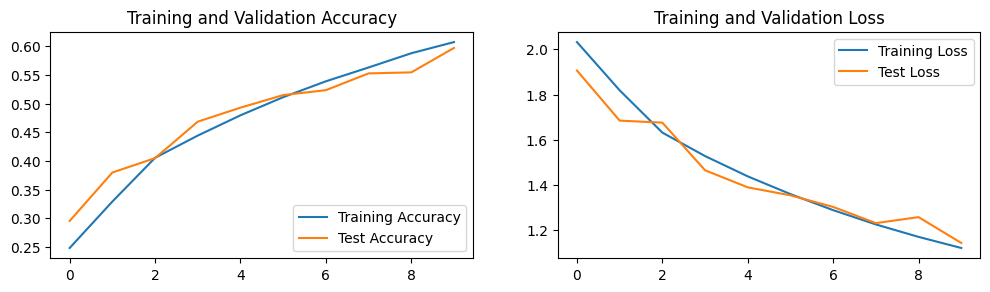

In [26]:
import matplotlib.pyplot as plt
#隐藏警告
import warnings
warnings.filterwarnings("ignore")               #忽略警告信息
plt.rcParams['font.sans-serif']    = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.rcParams['figure.dpi']         = 100        #分辨率

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()